# **Lab 2: Optimizing Generative AI Workloads on Arm Server Processors**

## **Introduction**

Welcome to the second lab in our series on **Optimizing Generative AI Workloads with Arm Processors**! In this hands-on session, you will build on the concepts learned in Lab 1 by learning how to vectorize AI workloads efficiently with the powerful intrinsics of Arm Neoverse Cloud processors. These include:

- **Neon** (for SIMD acceleration)
- **DotProd** (dot-product extension)
- **I8MM** (integer matrix multiplication)

We will learn about and utilize these intrinsics through the **KleidiAI library**, which provides optimized micro-kernels for matrix multiplication, the main workload of AI applications. You will also benchmark these kernels utilizing these different intrinsics to see their performance differences and compare the results to a benchmark library called **BLAS** which is the standard library for linear algebra routines. Beyond benchmarking, you will also integrate these optimized kernels into PyTorch to enable **quantized matrix multiplication**, and deploy your own highly optimized small language model on the cloud with **4-bit** quantization. 


### **Lab Objectives**

1. **Explore Advanced Arm Intrinsics**  
   Gain a deeper understanding of CPU intrinsics and learn how the specific intrinsics provided by Arm Neoverse, including **DotProd**, **I8MM**, and **SVE**, enhance performance. Explore how these intrinsics, available in modern Arm architectures, are utilized to accelerate matrix multiplication operations.

2. **Learn about the KleidiAI Library**  
   Discover how KleidiAI implements these intrinsics in micro-kernels and why it can outperform traditional approaches in certain use cases.

3. **Benchmark KleidiAI Against BLAS**  
   Implement and benchmark KleidiAI micro-kernels using different intrinsics against the **BLAS** library to quantify performance benefits.

4. **Quantize Matrix Multiplication in PyTorch**  
   Integrate the KleidiAI kernels into PyTorch to perform quantized matrix multiplications, comparing performance, and accuracy trade-offs.

5. **Implement and Evaluate 4-Bit Quantization**  
   Apply **groupwise int4 quantization** to the **OpenELM-3B** model, measuring **latency** and **memory** improvements on an Arm Neoverse server.

### **What you will learn**
- Learn how the different **vector processing units** in the **Neoverse processor** can be used to accelerate matrix multiplication. 
- How to implement and use highly optimized **micro-kernels** written in assembly to accelerate matrix multiplication. 
- How to integrate these the above accelerations into PyTorch and use them for the **inference of a large language model on the Cloud**.

### **Prerequisites**

- **Basic Knowledge of Linux**: Comfortable working in a Linux terminal.
- **C/C++ and Python Programming**: Familiarity with writing and compiling code.
- **Matrix Multiplication**: Understanding of linear algebra basics.
- **Completion of Lab 1 (Recommended)**: Familiarity with Neon vector instructions and quantization concepts.
- **Completion of Chapter 2 and 4**: Familiarity with language models, and Arm's vector processing units will be useful.


**By the end of this lab**, you will have hands-on experience combining low-level Arm intrinsics, specialized libraries, and quantization techniques to push the performance of large language models on Arm server processors. These skills will enable you to optimize generative AI workloads in both **resource-constrained** and **server-class** Arm environments.

<br>

---
### **Target Hardware for This Lab**

⚠️ **IMPORTANT:** This lab is designed to run on a **cloud instance with an Arm Neoverse Server Processor** (e.g. AWS Graviton3 or Graviton4). The optimizations rely on advanced CPU features (**NEON**, **DotProd**, **I8MM**) that are not available on typical laptops or standard cloud VMs.

If you do not already have access to an appropriate Arm server:

➡️ **Follow the setup instructions in `README.md` to provision a suitable cloud instance** and configure your environment.

✅ **Supported:**
- AWS EC2 with Graviton3 (C7g, M7g, R7g) or Graviton4 (C8g, M8g, R8g)
- Arm servers with Neoverse-N2, Neoverse-V1, or Neoverse-V2 cores

<br>

---

#### This lab is intended to be run **on an Arm Neoverse cloud instance**. If you are viewing this lab from your local machine, please first provision an appropriate instance following the `README.md` instructions.

---

<br>

# 1. Explore Advanced Arm Intrinsics 
Before we dive into the Arm intrinsic features of Neoverse processors, let's start by preparing example inputs for a matrix multiplication. To make this example relevant to a real neural network, we'll identify and extract the largest matrix multiplication operation used by the OpenELM Large Language Model. This can be done by running the following cells. The first cell downloads the model from Hugging Face, and the second uses a feature of PyTorch called model hooks to extract an example activation matrix and the relavant weight matrix. 


In [1]:
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True) # download the tokenizer
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-3B-Instruct", trust_remote_code=True) # download the model (this may take a while)

/home/ubuntu/Generative_AI_on_arm/graviton_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

configuration_openelm.py:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/apple/OpenELM-3B-Instruct:
- configuration_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_openelm.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/apple/OpenELM-3B-Instruct:
- modeling_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/home/ubuntu/Generative_AI_on_arm/graviton_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

### Collect Largest Weight matmul in LLM 
The output of the cell below should show you the dimensions of the matrix multiplication inputs. As you can see they are very large and given a matrix multiplication has 'O(sequence_length x input_channels x output_channels)' you can see why performing this operation could be so important for AI inference. 

In [2]:
import torch
import torch.nn.functional as F
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
activations = {} # Initialize to store the activations

prompt = "What is the best way to optimize the inference of a large language model for Arm Neoverse processors?"  # create a sample prompt for the llm 
inputs = tokenizer(prompt, return_tensors="pt") # tokenize the prompt ready for inputting into the model

# Define a hook function to capture output activation of each matrix multiplication
def get_activation_input(name):
    def hook(model, input, output):
        # 'input' is a tuple; we take the first element for the input tensor
        activations[name] = output[0]
    return hook


# the largest matmul is after the last normalization, We therefor apply the hook 
# on this layer to the the input for th last matmul which is the projection from 
# tokens to probabilities over the all possible tokens in the vocabulary.
layer = model.transformer.norm
hook_handle = layer.register_forward_hook(get_activation_input('token_activations'))

# Run the model forward pass
with torch.no_grad():
    model(**inputs)

# Extract the projection weight matrix and the input activation tensor from the hook
W = model.transformer.token_embeddings.weight.data.clone()
X = activations['token_activations']

hook_handle.remove()
print(f"The collected weight matrix has shape {W.shape[0]}x{W.shape[1]} (output_channels x input_channels)")
print(f"The collected activation tensor has shape {X.shape[0]}x{X.shape[1]} (sequence_length x input_channels)")

The collected weight matrix has shape 32000x3072 (output_channels x input_channels)
The collected activation tensor has shape 23x3072 (sequence_length x input_channels)


# Explanation

The above cell computes two key tensors:

1. **Activation Tensor `X`**: Shape \([23, 3072]\)  
   - This corresponds to 23 tokens in the input sequence, each represented by a 3072-dimensional embedding generated by the OpenElm transformer.

2. **Weight Matrix**: Shape \([32000, 3072]\)  
   - This is a matrix multiplication projection matrix, transforming each of the 3072-dimensional tokens into a 32,000-dimensional vector. Each of the 32,000-dimensional vectors are the logits for each of the 32,000 possible tokens in the vocabulary.

When we multiply these two tensors, their common dimension of 3072 aligns, producing an output of shape \([23, 32000]\). The first dimension corresponds to the 23 tokens in the sequence, and the second dimension corresponds to the 32,000 tokens in the vocabulary.

The resulting matrix provides the logits for every token in the vocabulary for each position in the sequence. These logits can then be used to generate probability distributions over the next predicted token. This distribution can be sampled to generate the next token in the sequence. 

Now that we have saved the inputs to the matrix multiplication, lets measure Torch's matrix multiplication latency from Python. We can use that as a reference to compare against when using the Arm intrinsics for further acceleration. 

### Benchmark Torch Latency for the 'matmul'

In [3]:
import time
import torch

def measure_time():
    start = time.perf_counter()
    with torch.no_grad():
        y = torch.mm(X, W.T)  # perform the matrix multiplication
    end = time.perf_counter()
    return (end - start) * 1e3  # Convert seconds to microseconds

# Run multiple times and average
times = [measure_time() for _ in range(10)]
torch_latency_us = sum(times) / len(times)  # Average in microseconds

print(f"{torch_latency_us:.2f} milliseconds")

57.01 miliseconds


Your output should be something order of 90 milliseconds. That is pretty good, but I think we can do better by utilizing the intrinsics that Neoverse provides. Lets dive into some low-level C++ to gain greater control and insight as to how the hardware is working. We however still want to use the same matrix multiply inputs as above so lets write them out to disk so our C++ programs can read the same example. 

In [4]:
!mkdir src/cpp/assets/

X.numpy().tofile("src/cpp/assets/x_fp32.bin") # write the activation tensor to disk 
W.numpy().tofile("src/cpp/assets/w_fp32.bin") # write the weight tensor to disk

## Naive 'matmul' Operator
We can again also write the naive implementation of the matrix multiplication in C++ without any parallelization, memory optimizations or vectorization. This is just like in the first lab except that the matrix multiplication is involving non-square matrices, and hence we have to pass the multiplication dimensions 'M, K, and N' which are integer values, defining the shape of the matrix multilication (read the code cell comments for more details). Note that we again store the matrices as a flat pointer, representing the matrices as a single vector in row-major order. (Go back to Lab 1 to learn about row-major if you are unsure)

In [5]:
%%writefile src/cpp/naive/kernel.cpp

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int M, int K, int N) {
    // # M: the number of rows in the left-hand matrix (M = A.shape[0])
    // # K: the inner dimensions of the multiple (K == A.shape[1] == B.shape[0])
    // # N: the number of columns in the right-hand matrix (N == B.shape[1])
    float accumulator = 0;
    for (int m = 0; m < M; m++) {
        for (int n = 0; n < N; n++) {
            accumulator = 0;
            for (int k = 0; k < K; k++) {
                accumulator += A[m * K + k] * B[k * K + n];
            }
            C[m * K + n] = accumulator;
        }
    }
}

Writing src/cpp/naive/kernel.cpp


### Benchmark the Naive Operator

We have written some benchmark code inside 'src/cpp/naive/benchmark_naive.cpp' that will measure the kernel's latency. You can build, compile, and run it using the cell below.

In [6]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/naive/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)
print(" ")
print("======> Benchmarking Naive Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_naive"], cwd=build_dir)
print("=========> Benchmark completed. <========== \n")


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.5s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build
[ 33%] Building CXX object CMakeFiles/benchmark_naive.dir/benchmark_naive.cpp.o
[ 66%] Building CXX object CMakeFiles/benchmark_naive.dir/kernel.cpp.o
[100%] Linking CXX executable benchmark_naive
[100%] Built target benchmark_naive
 
======> Benchmarking Naive Kernel <========
Time taken: 11 seconds
=========> Benchmark completed. <========== 



The naive kernel achieves a latency of approximately **12 seconds**, making it roughly **140 times slower** than PyTorch in Python. This is because PyTorch natively uses optimized operator kernels to perform matrix multiplication that are parallelized across processing cores. In this next section we will explore various matrix multiplication operator kernels, and see how they can harness the unique features of Arm Neoverse processors to accelerator the operation. In particular we will be using the KleidiAI library, which is a highly efficient matrix multiplication library written in C++ and Assembly specifically optimized for Arm devices. KleidiAI leverages advanced techniques such as micro-kernels and Arm intrinsics features to accelerate computation.

Let us start by cloning the KleidiAI library.

# Clone KleidiAI

In [7]:
!git clone https://git.gitlab.arm.com/kleidi/kleidiai.git

Cloning into 'kleidiai'...
remote: Enumerating objects: 5110, done.
remote: Counting objects: 100% (3704/3704), done.
remote: Compressing objects: 100% (875/875), done.
remote: Total 5110 (delta 3219), reused 2891 (delta 2815), pack-reused 1406 (from 1)
Receiving objects: 100% (5110/5110), 3.63 MiB | 12.73 MiB/s, done.
Resolving deltas: 100% (3219/3219), done.


## Understanding the KleidiAI Micro-Kernel

The KleidiAI micro-kernel, available from the KleidiAI library is a minimal, highly optimized piece of code designed to accelerate specific machine learning operations on Arm CPUs. Unlike typical kernels or functions, micro-kernels are crafted to provide flexibility in how they process data, allowing them to handle portions of an output tensor rather than requiring the entire operation to be completed in one step. This flexibility enables efficient parallelization across multiple threads and improves performance by tailoring the computation to different hardware architectures and output tile sizes. For instance, you can partition a single matrix multiplication into multiple blocks of computation, and pass each of these blocks to a KleidiAI micro-kernel accross different processing cores, thereby increasing throughput. 

Micro-kernels are available in different variants, each optimized for specific Arm architectures, technologies, and computational parameters. Despite these variations, all micro-kernel variants of the same type perform the same operation and produce identical results, ensuring consistency across different hardware and configurations. We will next go through variations of KleidiAI micro-kernels, learn about their naming conventions, and the technologies they use to accelerate our matrix multiplcation example. First up, is the Neon SIMD processing concept that we learn't about in Lab 1 for the floating-point 32 precision. 

## Creating a Kleidi Kernel

The KleidiAI micro-kernels are located in the kleidiai/kai/ukernels directory. These variants follow a specific naming convention:

`kai_matmul_<fused_ops>_<dst_info>_<lhs_info>_<rhs_info>_<mr x nr x kacc>_<technology>_<feature>_<instruction>`


In this convention:
- `fused_ops` specifies additional operations integrated with the matrix multiplication. For example, `clamp` represents an operation that clamps the input activations to ensure numerical stability.
- `dst_info` defines the output data type.
- `lhs_info` provides information about the input data type, referring to where the activation tensor is supplied.
- `rhs_info` specifies the data type of the weights.

You can refer to the [repository documentation](https://gitlab.arm.com/kleidi/kleidiai/-/tree/main/kai/ukernels/matmul?ref_type=heads) for a detailed explanation of the naming conventions used for data types. 

For now, we will explore several examples and explain their components step by step, starting with floating-point 32 matrix multiplication.

# FP32 NEON MLA

In [8]:
%%writefile src/cpp/f32_f32_f32p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla.h"
#include "kai_matmul_clamp_f32_f32_f32p_interface.h"


constexpr kai_matmul_clamp_f32_f32_f32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_n_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_nr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_kr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_sr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_size_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_run_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla};

Writing src/cpp/f32_f32_f32p/kernel.cpp


The above cell defines a **KleidiAI micro-kernel** with the struct name:

`kai_matmul_clamp_f32_f32_f32p_ukernel`


Here, `f32` is used for both `lhs_info` and `dst_info`, meaning the input activation tensor and output data use **32-bit floating-point precision**. The `rhs_info` is also `f32`, but with a `p` suffix, indicating that the weight matrix must be **packed** in a specific format.

Packing the weight matrix optimizes **memory alignment**, improving **memory locality**, **cache efficiency**, and **access patterns**. By applying **tiling, loop unrolling, Neon SIMD vectorization**, and **packed weights**, the micro-kernel minimizes memory latency and maximizes computational throughput, significantly reducing overall latency compared to a naive implementation.

### Build and Benchmark the 32-bit Floating-Point Kernel 

In [9]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_f32_f32p/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI FP32 Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_f32"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- The ASM compiler identification is GNU
-- Found assembler: /usr/bin/cc
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[  5%] Building CXX object CMakeFiles/benchmark_f32.dir/benchmark_f32.cpp.o
[ 11%] Building CXX object CMakeFiles/benchmark_f32.dir/kernel.cpp.o
[ 16%] Building C object CMakeFiles/benchmark_f32.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/matmul_cl

The result should show a **latency in the range of ten milliseconds**, which is impressive. By using the **KleidiAI kernels**, we achieve a **1000x improvement in latency** compared to the naive kernel and this is without applying any quantization.  

To better understand how this performance is achieved, we can use a tool called 'process watch' to examine the intrinsics used by the operator. Please follow the instructions below carefully. There are four steps:

**Step 1:**  Run the first code cell below. This will execute the matrix multiplication in an **infinite loop**, ensuring that the process does not terminate. The output will include a **Process ID (PID)**, which we will use to analyze the computation.

**Step 2:**  Copy the **PID** from the first cell and paste it into the second cell after the `-p` flag. This will configure the 'process watch' tool to monitor the running matrix multiplication process and display its analysis in real time.

**Step 3:**  Once the analysis has been printed a few times, **interrupt the kernel** to stop the output.  
To do this, go to the **top-left menu** in JupyterLab, click on **Kernel**, and select **Interrupt Kernel**.

**Step 4:**  Finally, run the third code cell to **terminate the matrix multiplication process**.


Using 'Process Watch' we can check what kernels are being run:

In [10]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_f32_f32p/build/kai_f32_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 15607


In [11]:
!sudo ./processwatch/processwatch -p 15607 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              71.96    0.00     0.00     0.00     0.00     100.00   31292   
15607    kai_f32_inf      71.96    0.00     0.00     0.00     0.00     100.00   31292   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              71.52    0.00     0.00     0.00     0.00     100.00   31604   
15607    kai_f32_inf      71.52    0.00     0.00     0.00     0.00     100.00   31604   
^C


In [12]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

The analysis should show roughly 70% of the machine instructions are using the Neon SIMD registers, and hence making very effective use of vectorization. Next we can implement the exact same matrix multiplication with the KleidiAI library using the cell below but utilizing FP16 precision not FP32. This saves half the memory bandwidth. 

# FP16 NEON MLA 

Next up is the FP16 kernel. This uses the floating-point 16 precision with just 16 bits as opposed to FP32 that uses 32. Using half the memory per element reduces the load on memory bandwidth as less data needs to be read and written to DRAM.

In [13]:
%%writefile src/cpp/f16_f16_f16p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla.h"
#include "kai_matmul_clamp_f16_f16_f16p_interface.h"

constexpr kai_matmul_clamp_f16_f16_f16p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_n_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_nr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_kr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_sr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_size_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_run_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla};

Writing src/cpp/f16_f16_f16p/kernel.cpp


### Build and Benchmark the 16-bit Floating-Point Kernel 

In [14]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f16_f16_f16p/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI FP16 Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_f16"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[  6%] Building CXX object CMakeFiles/benchmark_f16.dir/benchmark_f16.cpp.o
[ 13%] Building CXX object CMakeFiles/benchmark_f16.dir/kernel.cpp.o
[ 20%] Building C object CMakeFiles/benchmark_f16.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/matmul_clamp_f16_f16_f16p/kai_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla.

Your benchmark for the **FP16 kernel** should be around **6 milliseconds**, showing an improvement over the previous **FP32 kernel**. This performance gain is due to the **Neoverse architecture’s native support for FP16 data types**.  

Since FP16 precision uses **half the number of bits** compared to FP32, the **memory bandwidth requirement** for reading and writing from main memory is significantly reduced. This reduction lowers the bandwidth load and improves **cache utilization**, increasing the **cache hit rate** and further reducing latency.  

Now, let's analyze the computational workload using **processwatch**. Please follow the same **four steps** used for the **FP32 kernel**.


In [15]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f16_f16_f16p/build/kai_f16_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 15777


In [16]:
!sudo ./processwatch/processwatch -p 15777 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              85.08    0.00     0.00     0.00     0.00     100.00   31214   
15777    kai_f16_inf      85.08    0.00     0.00     0.00     0.00     100.00   31214   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              85.45    0.00     0.00     0.00     0.00     100.00   31200   
15777    kai_f16_inf      85.45    0.00     0.00     0.00     0.00     100.00   31200   
^C


In [17]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

The **process watch** should indicate an increase in the percentage of **Neon instructions utilized** compared to **FP32 operations**. This is because **FP16** **operations** reduce memory bandwidth requirements when reading and writing half-precision activations and weights, compared to full-precision.

As a result, the CPU can allocate more cycles to computation rather than being stalled by memory access, leading to **higher overall computational efficiency**.  

Now, let's explore some of the **key features of Arm Neoverse architectures** that can further accelerate AI workloads.


## DotProd

The next extension we will introduce is **DotProd**. This extension uses **dot-product instructions**, providing a powerful way to perform **multiply-accumulate operations on vectors**. These instructions efficiently **multiply rows and columns** of weight and activation matrices for full matrix multiplication.  

There are two types of dot-product instructions:  

- **SDOT**: signed dot product  
- **UDOT**: unsigned dot product  

### **How They Work**  

These instructions operate on **32-bit elements** packed inside larger vectors (either **64-bit, 128-bit Neon vectors, or scalable vectors in SVE2**). Each 32-bit element contains **four 8-bit sub-elements**. The dot-product process follows these steps:

1. **Multiply**: Each **8-bit** **element** in each 32-bit segment of the first vector is multiplied by the corresponding **8-bit element** in the second vector.  
2. **Accumulate Products**: The **four resulting products** within each 32-bit segment are summed to produce a new **32-bit value**.  
3. **Add to Destination**: Each 32-bit sum is added to the corresponding **32-bit element** in the destination vector.  

This effectively computes an **inner product (dot product)** for each group of four 8-bit pairs. For example, the first 32-bit element is updated as follows:


c0 = c0 + ( (a0 * b0) + (a1 * b1) + (a2 * b2) + (a3 * b3) )


### **Performance Benefits**  

The dot-product instructions are optimized for **parallel computation**:

- **Arm Cortex-X2** and **Arm Neoverse V1** can execute **four dot-product instructions in parallel**.  
- This enables them to process **four 128-bit operations per cycle**.  
- Each 128-bit operation consists of **four groups of four 8-bit multiply-accumulates**, resulting in **64 multiply-accumulate operations per cycle**.  

Now, let's see it in action!  

First, we need to define the **KleidiAI micro-kernel** that utilizes **DotProd** instructions.

In [18]:
%%writefile src/cpp/f32_i8_i4_dotprod/kernel.cpp

#include <arm_neon.h>
#include <string>

#include "kai_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_mr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_nr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_kr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_sr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_run_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod};

Writing src/cpp/f32_i8_i4_dotprod/kernel.cpp


The naming convention for this kernel may seem complex at first, but let's break it down step by step:

### Destination Information (`dst_info`)
- **`dst_info`**: This part is similar to the previous format using `f32`, indicating that the output of the matrix multiplication is a 32-bit tensor.

### Left-Hand Side Information (`lhs_info`)
- **`lhs_info`**: The identifier `qsi8d32p` carries detailed information about the left-hand side tensor:
  - **`q`**: indicates that the tensor is quantized.
  - **`s`**: specifies that the quantization is symmetric.
  - **`i8`**: the quantized data type is 8-bit integer (`int8`).
  - **`d32`**: signifies per-dimension quantization, meaning there is one scalar quantization parameter for each dimension.
  - **`p`**: indicates that the matrix must be **packed** for efficient processing.

### Right-Hand Side Information (`rhs_info`)
- **`rhs_info`**: The identifier `qsi4c32p` describes the right-hand side tensor:
  - **`q`**: indicates that the tensor is quantized.
  - **`s`**: specifies that the quantization is symmetric.
  - **`i4`**: the quantized data type is 4-bit integer (`int4`).
  - **`c32`**: means per-group quantization, with a single scale parameter for every 32 elements in the tensor.
  - **`p`**: indicates that the matrix must be **packed**.

### Build and Run 

In [19]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_i8_i4_dotprod/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI Int8 DotProd Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_dotprod"], cwd=build_dir)
print("=================> Benchmark completed. <================= \n")

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[  5%] Building CXX object CMakeFiles/benchmark_dotprod.dir/benchmark_i8_dotprod.cpp.o
[ 11%] Building CXX object CMakeFiles/benchmark_dotprod.dir/kernel.cpp.o
[ 16%] Building C object CMakeFiles/benchmark_dotprod.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/matmul_clamp_f32_qsi8d32p_qsi4c32p/kai_matmul_clamp_f32_qsi

Now run the cell below, to start of the process, then copy the PID and paste it in the next cell to analyze the process.

In [20]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_dotprod/build/kai_i8_dotprod_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 15954


In [21]:
!sudo ./processwatch/processwatch -p 15954 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              55.54    0.00     0.00     0.00     6.84     100.00   31309   
15954    kai_i8_dotprod_  55.54    0.00     0.00     0.00     6.84     100.00   31309   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              55.18    0.00     0.00     0.00     6.72     100.00   31296   
15954    kai_i8_dotprod_  55.18    0.00     0.00     0.00     6.72     100.00   31296   
^C


In [22]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

'Process Watch' should show you in the DotProd column that roughly 5% of the instructions utilize the dot-product extension, indicating the kernel is sucessfully utilizing the acceleration extension. 

## i8mm Extension  

The next extension we will use is **i8mm**, which leverages the **SMMLA** instruction to efficiently perform **matrix multiply-accumulate** operations on **8-bit integer data types**. This extension is designed for small matrix multiplications, operating on **2×8 and 8×2 matrices** of signed 8-bit integers and producing a **2×2 matrix of 32-bit results**, which are then accumulated into a destination register.  

### **How SMMLA Works**  

This vector instruction takes two **16-element signed 8-bit vectors** and interprets them as small matrices:  
- The **first source vector** is treated as a **2×8 matrix**.  
- The **second source vector** is treated as an **8×2 matrix**.  

The computation proceeds in two steps:  

1. **Matrix Multiplication**: The two matrices are multiplied, yielding a **2×2 matrix of 32-bit integer products**.  
2. **Accumulate Results**: Each element of this **2×2 matrix** is added to the corresponding element in the **destination vector**, accumulating results efficiently.  

Since **SMMLA** performs **eight parallel dot-product computations** per output element, it can execute **eight multiply-accumulate operations simultaneously**.

### **Performance Characteristics**  

SMMLA is optimized for **high throughput**, designed to **match or exceed the combined throughput of two SDOT instructions** in a scalar context by increasing parallelism. For architectures implementing **i8mm**, this results in:  

- **High efficiency** in performing multiple **multiply-accumulate operations** in parallel.  
- **Optimized matrix computations** for **dot-product-based workloads**.  

In summary, **SMMLA** leverages the **i8mm extension** to accelerate **small matrix multiplications**, combining multiple **8-bit multiply-accumulate operations** in a single instruction. This makes it a powerful tool for **high-performance computing tasks** on **Arm processors**.


In [23]:
%%writefile src/cpp/f32_i8_i4_i8mm/kernel.cpp

#include <arm_neon.h>
#include "kai_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_mr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_nr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_kr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_sr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_run_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm};



Writing src/cpp/f32_i8_i4_i8mm/kernel.cpp


## Understanding the i8mm micro-kernel

This kernel follows the same structured naming convention as before, but now introduces **quantized 8-bit and 4-bit integer data types**.

### **Destination (`dst_info`)**  
- **`f32`**: The output is a **32-bit floating-point tensor**.

### **Left-Hand Side (`lhs_info`)**  
- **`qsi8d32p`**:  
  - **`q`**: quantized tensor  
  - **`s`**: symmetric quantization  
  - **`i8`**: 8-bit integer format (`int8`)  
  - **`d32`**: per-dimension quantization  
  - **`p`**: packed matrix  

### **Right-Hand Side (`rhs_info`)**  
- **`qsi4c32p`**:  
  - **`q`**: quantized tensor  
  - **`s`**: symmetric quantization  
  - **`i4`**: 4-bit integer format (`int4`)  
  - **`c32`**: per-group quantization (one scale per 32 elements)  
  - **`p`**: packed matrix 

### Build and Run 

In [24]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_i8_i4_i8mm/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI Int8 I8MM Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_i8_i8mm"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
[  5%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/benchmark_i8_i8mm.cpp.o
[ 11%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/kernel.cpp.o
[ 16%] Building C object CMakeFiles/benchmark_i8_i8mm.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/matmul_clamp_f32_qsi8d32p_qsi4c32p/kai_matmul_clamp_f32_qsi8d32p4

In [25]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_i8mm/build/kai_i8_i8mm_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")


Main process ID: 16131


In [26]:
!sudo ./processwatch/processwatch -p 16131 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              40.18    0.00     0.00     6.02     0.00     100.00   31307   
16131    kai_i8_i8mm_inf  40.18    0.00     0.00     6.02     0.00     100.00   31307   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              40.43    0.00     0.00     6.16     0.00     100.00   31282   
16131    kai_i8_i8mm_inf  40.43    0.00     0.00     6.16     0.00     100.00   31282   
^C


In [27]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

### **Plot Latency Scaling**  

Now that we have successfully utilized the **Arm Neoverse** hardware extensions, let's benchmark their performance **against each other** across different matrix sizes.  

As a baseline, we will also include the **OpenBLAS** library, which is the **standard open-source backend** for highly optimized matrix multiplications. It is commonly used as the default CPU backend for **PyTorch**.  

Next, we will define a set of matrix sizes and measure **matrix multiplication latency** using the following cell.


In [28]:
%%writefile src/cpp/common/sizes.cpp

int sizes[] = {32, 64, 128, 256, 512, 1024, 2048};

Overwriting src/cpp/common/sizes.cpp


### Build and Benchmark Scalability

In [29]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define projects with their build directories and benchmark executables
projects = {
    "src/cpp/f32_f32_f32p/build": "benchmark_f32_scaling",
    "src/cpp/f16_f16_f16p/build": "benchmark_f16_scaling",
    "src/cpp/f32_i8_i4_dotprod/build": "benchmark_dotprod_scaling",
    "src/cpp/f32_i8_i4_i8mm/build": "benchmark_i8_i8mm_scaling",
    "src/cpp/blas/build": "blas_scaling_benchmark"
}

for build_dir, benchmark in projects.items():
    os.makedirs(build_dir, exist_ok=True)
    print(f"Building in {build_dir}...")
    subprocess.run(["cmake", ".."], cwd=build_dir, check=True)
    subprocess.run(["make"], cwd=build_dir, check=True)
    print(f"Running {benchmark}...")
    subprocess.run([f"./{benchmark}"], cwd=build_dir, check=True)


Building in src/cpp/f32_f32_f32p/build...
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 33%] Built target benchmark_f32
[ 38%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/benchmark_f32_scaling.cpp.o
[ 44%] Linking CXX executable benchmark_f32_scaling
[ 66%] Built target benchmark_f32_scaling
[100%] Built target kai_f32_inf
Running benchmark_f32_scaling...
Building in src/cpp/f16_f16_f16p/build...
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[ 33%] Built target benchmark_f16
[ 40%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 46%] Linking CXX executable benchmark_f16_scaling
[ 66%] Built target benchmark_f16_scaling
[100%] Built target kai_f16_inf
Running benchmark_f16_scaling...
Building in src/cpp/f32_i8_i4_dotprod/build.

## Plot the scaling results

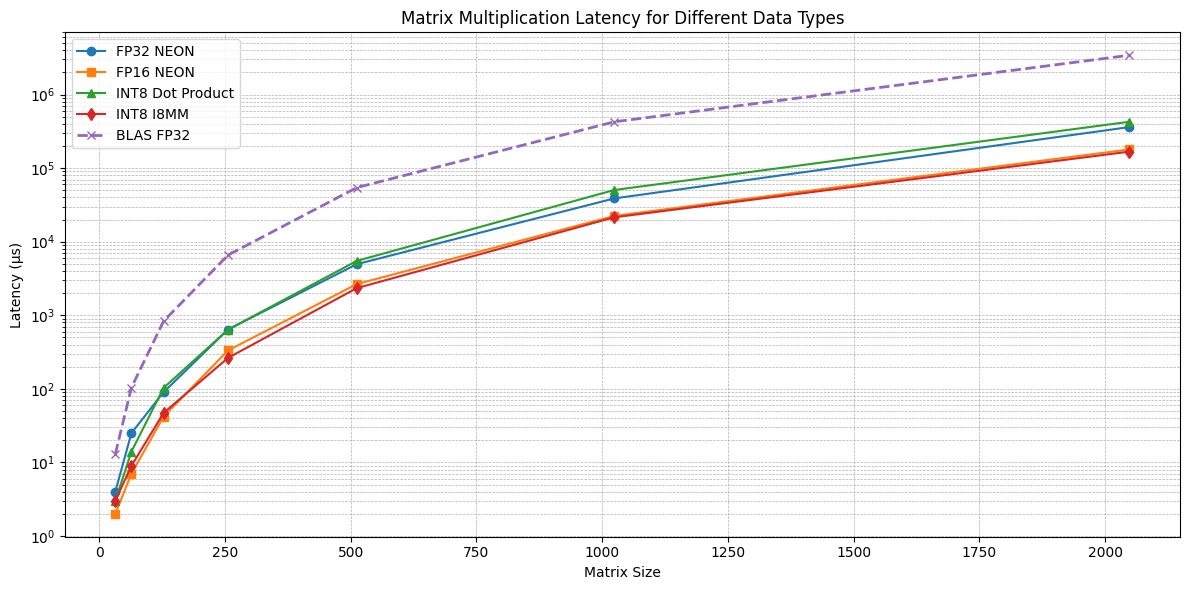

In [30]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 

# Load datasets
f32_data = pd.read_csv("src/cpp/results/f32_scaling_results.csv")
f16_data = pd.read_csv("src/cpp/results/f16_scaling_results.csv")
int8_dotprod_data = pd.read_csv("src/cpp/results/i8_dotprod_scaling_results.csv")
int8_i8mm_data = pd.read_csv("src/cpp/results/i8_i8mm_scaling_results.csv")
blas_data = pd.read_csv("src/cpp/results/blas_f32_scaling_results.csv")

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot each dataset
plt.plot(f32_data['Size'], f32_data['Latency(us)'], label="FP32 NEON", marker='o')
plt.plot(f16_data['Size'], f16_data['Latency(us)'], label="FP16 NEON", marker='s')
plt.plot(int8_dotprod_data['Size'], int8_dotprod_data['Latency(us)'], label="INT8 Dot Product", marker='^')
plt.plot(int8_i8mm_data['Size'], int8_i8mm_data['Latency(us)'], label="INT8 I8MM", marker='d')
plt.plot(blas_data['Size'], blas_data['Latency(us)'], label="BLAS FP32", marker='x', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel("Matrix Size")
plt.ylabel("Latency (µs)")
plt.title("Matrix Multiplication Latency for Different Data Types")
plt.yscale('log')  # Use log scale for latency if the values span multiple orders of magnitude
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()



From the scaling graph, the *x*-axis represents the matrix size, while the *y*-axis shows the matrix multiplication latency measured in microseconds. The graph clearly indicates that all implementations of KleidiAI matrix multiplications outperform the BLAS library. This suggests that, to optimize inference on Arm CPUs, it is highly beneficial to use the KleidiAI library as the backend for linear algebra operations.

Among the implementations, the int8 matrix multiplication (i8mm extension) is the fastest. This performance advantage is intuitive because the SMMLA instructions execute multiple dot products in parallel, leveraging the hardware capabilities efficiently. The next best performer is the floating-point 16-bit kernel, which utilizes Neon vectors and SIMD processing to accelerate computations.

**Let's now use KleidiAI as a backend to optimize the inference of the OpenELM Large Language Model.**

---
# **Quantizing a Large Language Model with KleidiAI**  

Low-level languages like **C++ and Assembly** provide fine-grained control over CPU hardware but can slow down rapid experimentation with **generative AI models**. In contrast, high-level frameworks like **PyTorch** simplify model development but rely on complex internal processes.  

For example, when you call a high-level function like:  

```python
torch.matmul(A, B)
```

PyTorch automatically dispatches the operation to optimized low-level kernels, such as those from BLAS or KleidiAI.

To bridge the gap between Python's flexibility and specialized low-level performance, especially on Arm architectures, we need to integrate KleidiAI kernels into PyTorch. Fortunately, much of the groundwork has already been done by Arm engineers, allowing us to focus on implementation rather than integration.

Let's start by exploring PyTorch’s 4-bit matrix multiplication operator, which leverages these optimized KleidiAI kernels for efficient computation.





In [31]:
# some imports 
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torchao.quantization.utils import prepare_int4_weight_and_scales_and_zeros
from torchao.utils import find_multiple

2025-06-12:20:37:31,179 INFO     [GPTQ.py:44] lm_eval is not installed, GPTQ may not be usable


### Set some 'matmul' Hyperparameters 
Here we are going to set some dimensions for a matrix multiplication. 

In [32]:
out_features = 2048 # number of output channels of the matrix multiplication 
in_features = 1024 # number of input channels of the matrix multiplication 
groupsize = 32 # number of weights per quantization scale parameter

#### Create the Floating-Point Matrices for the 'matmul'

In [33]:
weight = torch.randn(out_features, in_features, dtype=torch.float32) 
x = torch.randn(1, in_features, dtype=torch.float32)

## **Using TorchAO for Group Quantization**  

In **Lab 1**, we explored **per-tensor** and **per-channel quantization**, observing the benefits of increasing **quantization granularity** from a single scale per tensor to a separate scale per channel. Now, we take this one step further with **per-group quantization**, also known as **group quantization**.  

### **What is Group Quantization?**  
Instead of treating each channel in the weight matrix independently, **group quantization** partitions the output channels into **$G$ groups**. For example, if the weight matrix **$\mathbf{W}$** has **$m$ output channels**, each group contains **$\frac{m}{G}$ contiguous weights** (though different grouping strategies can be used).  

$$
\text{Groups} = \{\mathcal{G}_1, \mathcal{G}_2, \dots, \mathcal{G}_G\},
$$  

where each **$\mathcal{G}_k$** is a set of channel indices.  

### **Step 1: Compute the Scale Factor**  
Each group **$\mathcal{G}_k$** is quantized independently by computing a single **scale factor** **$S_{w_k}$**, found by taking the **maximum absolute value** within the group:

$$
S_{w_k} = \frac{\max_{i \in \mathcal{G}_k} \bigl|\mathbf{W}_i\bigr|}{2^{b-1} - 1}.
$$  

where:  
- **$\mathbf{W}_i$** denotes the weights index by **$i$**,  
- **$b$** is the quantization bit-width (e.g., **8 bits**).  

### **Step 2: Quantization and Dequantization**  
Once the scale factors are determined, we perform **two key operations**:

1. **Quantization**  
   Convert each weight into an integer representation by dividing by the scale factor and rounding:  

   $$
   Q_{w_i} = \text{round}\Bigl(\frac{\mathbf{W}_i}{S_{w_k}}\Bigr)
   \quad\text{for each } i \in \mathcal{G}_k.
   $$  

2. **Dequantization**  
   Recover the approximate floating-point weights by multiplying by the same scale factor:  

   $$
   \hat{\mathbf{W}}_i = Q_{w_i} \cdot S_{w_k}
   \quad\text{for each } i \in \mathcal{G}_k.
   $$  

### **Using TorchAO for Group Quantization**  
Luckily, **TorchAO** provides a built-in function to automate this process, making group quantization easy to implement.



In [34]:
w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
    weight, # the weight tensor to be quantized to 4 bit
    groupsize, # the number of weight elements per group (32 in this example) 
    None, # this argument is not required
    "symmetric_groupwise", # the quantization type 
    precision=torch.float32, # precision for the scale parameters
)

### Look at the Shapes To See What Has Been Done 

In [35]:
print(f"Full-precision weights: shape {weight.shape} dtype {weight.dtype}")
print(f"Prepared weights: shape {w_int4x8.shape} dtype {w_int4x8.dtype}")
print(" ")
print("weight number equality: ", w_int4x8.numel(), "==", weight.numel()//2 + (weight.numel()//groupsize * 2))

Full Precision weights: shape torch.Size([2048, 1024]) dtype torch.float32
Prepared weights: shape torch.Size([65536, 18]) dtype torch.uint8
 
weight number equality:  1179648 == 1179648


### **Explanation of the Prepared Weights Size**

In the example above, the full-precision weights, originally stored as a `torch.float32` tensor with shape `[2048, 1024]`, have been converted into a `uint8` tensor with shape `[65536, 18]`. To understand this transformation, we can use the equality described in the previous cell. This equation defines the relationship between the number of elements in the full-precision weight tensor and the corresponding `int4` quantized weights. For clarity, it is written below:

> **Note:** `.numel()` returns the total number of elements in a PyTorch tensor.

```python
w_int4x8.numel() == (weight.numel() // 2) + (weight.numel() // groupsize * 2)
```

To explain this relationship, let's recall the principles of 4-bit quantization. In this scheme, we need to quantize the weights from `float32` to `int4`. However, `int4` is not directly supported in PyTorch since most hardware manipulates memory in bytes (8 bits). As a result, two `int4` values are packed into a single byte (`uint8`), which is an 8-bit datatype.

#### **Breaking Down the Equation**
1. **Half the number of weights:**  
   - Since each full-precision weight is mapped to a 4-bit representation, and two 4-bit values fit into a single byte, the storage required is halved.  
   - This is captured by the term:  
     ```python
     weight.numel() // 2
     ```

2. **Storage for scale parameters:**  
   - Each group of weights has a corresponding scale factor. The number of groups is given by:  
     ```python
     weight.numel() // groupsize
     ```
   - These scale factors are stored in `float16` format, requiring 2 bytes per scale. Hence, the storage required for all scale factors is:  
     ```python
     (weight.numel() // groupsize) * 2
     ```

Adding both terms together:

```python
(weight.numel() // 2) + (weight.numel() // groupsize * 2)
```

gives the total storage (in bytes) required for the quantized weights and scale parameters. This total matches the number of elements in `w_int4x8`, explaining why the tensor shape changes to `torch.Size([65536, 18])`.

### **But Why Does the Shape Change?**


In [36]:
w_int4x8.shape

torch.Size([65536, 18])

The weight preparation function has performed group quantization, quantizing each group to a single row in the matrix. This gives `weight.numel()//group_size` rows. We can check that it is true using the below line 

In [37]:
weight.numel() // groupsize

65536

Ok, so that means that there is one group per row, each one with their own scale parameter. Given that the groupsize we have used is 32, and when using 4-bit quantization we can pack two elements into a single byte, that gives a row size of 16 bytes. This leaves a discrepancy of 2 bytes. This 2 byte difference is used to hold the symmetric scale parameter in float16 format. Therefore the row size of w_int4x8 is: 

In [38]:
groupsize // 2 + 2

18

# Packing the weight 

After performing the quantization, as we saw in with the KleidiAI C++ operators we must pack the weight into the required memory layer required to achieve fast inference. We can do that with the following code. 

***Note:*** *For the symmetric groupwise quantization scheme the  scales_and_zeros tensor is a empty, as the scales are stored in the weight tensor itself.*** 

In [39]:
weight_int4pack = torch.ops.aten._kai_weight_pack_int4(w_int4x8, scales_and_zeros.float(), out_features, in_features, groupsize)

### AP	Function To Use the Kleidi int4 Kernel 

In [40]:
def linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features):
    origin_x_size = x.size() # the number of elements in the tensor 
    c = torch.ops.aten._kai_input_quant_mm_int4(x, weight_int4pack, x.shape[-2],out_features, in_features, 32) # perform the matmul with the KleidiAI kernel 
    new_shape = origin_x_size[:-1] + (out_features,) #reshape to 
    c = c.reshape(new_shape)
    return c

In [41]:
out_int4 = linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features)

## Lets Have a Look at the Quantization Error

So up to now, we have quantized and run a matrix multiplication withe the symmetric groupwise quaniztion scheme with the KleidiAI operators for high performance. Lets check have a look at the output and compare it to the multiplication in full preceision ('torch.float32')

In [42]:
out_baseline = torch.matmul(x, weight.T) # compute the baseline operation
print(out_int4.flatten()[:5])
print(out_baseline.flatten()[:5])
error = (out_baseline - out_int4).abs()

tensor([ 7.6354, 56.0428, 37.3249, -4.6296,  7.8555])
tensor([ 9.7623, 53.2890, 37.4203, -3.1001,  7.1882])


Ok so the ouputs are fairly similiar indicating the error introduced by symmetric groupwise quantization is small. Let's look at the distribution of quantization errors. 

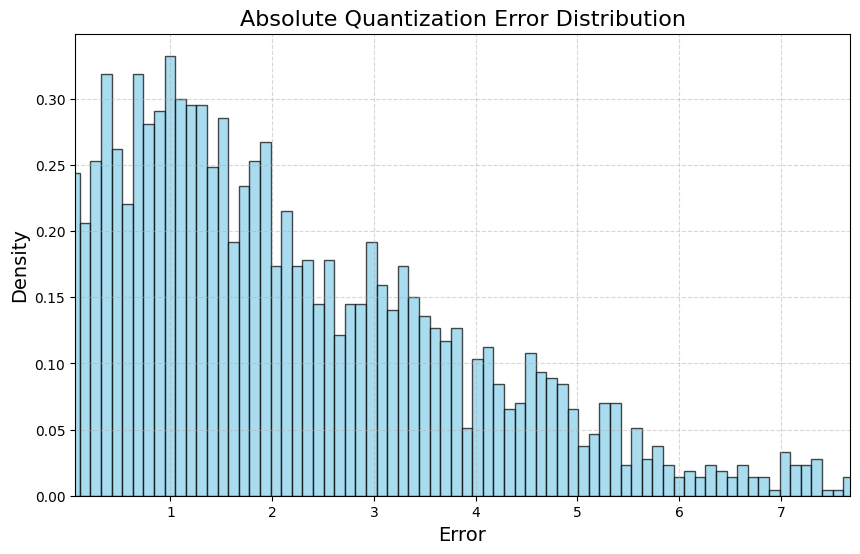

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'error' is your data tensor
data = error.flatten().numpy()

plt.figure(figsize=(10, 6))

# Plot the histogram with fewer bins and density normalization
plt.hist(data, bins=100, color='skyblue', edgecolor='black', alpha=0.7, density=True)

# Add titles and labels
plt.title('Absolute Quantization Error Distribution', fontsize=16)
plt.xlabel('Error', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Optionally, set x-axis limits to exclude extreme outliers
# For example, between the 1st and 99th percentiles
lower, upper = np.percentile(data, [1, 99])
plt.xlim(lower, upper)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

The plot should show a roughly Gaussian decreasing error with the majority of errors below 5, indicating we have successfuly quantized the matrix multiplication. 

## Quantizing the OpenELM Model with KleidiAI

Now that we’ve learned how to quantize a matrix multiplication — the core operation of the linear projection layer commonly used in large language models — we can create a custom int4 weight-only linear layer using the KleidiAI kernel with symmetric groupwise quantization. An incomplete implementation of this layer is provided in the cell below.

**Exercise:** Your task is to complete the forward method of the `In4WeightOnlyKAILinear` class using the previously defined KleidiAI with PyTorch kernel. Make sure to handle the addition of the bias term if it is present!

**NOTE** if you are stuck you can use an example solution at the end of the notbook.

In [44]:
class Int4WeightOnlyKAILinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.register_buffer(
            "weight",
            torch.zeros((torch.ops.aten.get_kai_weight_pack_int4_size(out_features,in_features,groupsize)), dtype=torch.uint8)
        )

        self.register_buffer(
            "scales_and_zeros",
            torch.zeros((0), dtype=torch.float32)
        )

        if bias is not False: 
            self.register_buffer(
                "bias",
                torch.zeros((self.out_features), dtype=torch.float32)
            )
        else: 
            self.register_buffer("bias", None)

    def forward(self, x):
        print("========", x.shape)
        # =========== Your code goes here ============
        raise NotImplementedError("You must add your code for exercise 1")
        # ============================================

### Let's Run a Test To Make Sure Your Solution Is Correct

In [45]:
from IPython.display import display, HTML

layer4bit = Int4WeightOnlyKAILinear(in_features, out_features, bias=True)
x = torch.randn(1, in_features)
out = layer4bit(x)
if out.dtype == torch.float32 and out.shape == (1, out_features):
    display(HTML("<div style='color: green; font-size: 20px;'>Success! Test Passed</div>"))
else: 
    display(HTML("<div style='color: red; font-size: 20px;'>Failed. Test Failed. Please try again.</div>"))
    

If you have passed that test we can use the next cell to instantiate your new quantized layer with the weights of an normal full-precision `nn.Linear` layer 

In [46]:
def quantize_linear_layer(layer):
    fp_weight = layer.weight.data.detach()
    out_features = layer.out_features
    in_features = layer.in_features

    # quantize the weights 
    w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
        fp_weight, # full precision weight matrix from the original layer
        groupsize=32, # group size 
        inner_k_tiles=None, # Not required input
        scheme="symmetric_groupwise",
        precision=torch.float32
    )

    # pack the weights 
    weight_int4pack = torch.ops.aten._kai_weight_pack_int4(
        w_int4x8, 
        scales_and_zeros.float(), 
        out_features, 
        in_features, 
        groupsize
    )

    # create the your 4-bit quantized layer 
    use_bias = layer.bias is not None
    layer4bit = Int4WeightOnlyKAILinear(in_features, out_features, use_bias)

    # copy the weights from the original layer which we have quantized to the new layer 
    layer4bit.weight = weight_int4pack
    layer4bit.scales_and_zeros = scales_and_zeros
    if use_bias:
        layer4bit.bias.data.copy_(layer.bias.data)

    return layer4bit


Next, we will define a functon to replace all `nn.Linear` layer of a PyTorch model (`nn.Module`) with our very own quantized `Int4WeightOnlyKAILinear`

In [47]:
def quantize_model(model):
    for name, child in model.named_children():
        if isinstance(child, nn.Linear):
            # Quantize the linear layer
            quantized_layer = quantize_linear_layer(child)
            setattr(model, name, quantized_layer)
        else:
            # Recursively apply to child modules
            quantize_model(child)
    return model

Now lets load the OpenELM LLM that we want to quantize along with its tokenizer so we can prompt it. 

In [48]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer


model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-3B-Instruct", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)

prompt = "Quantization is the process of reducing the precision or/and activations in order to reduce the memory footprint of a model and improve its inference latency. In particular weight-only symmetric quantization for language models"
inputs = tokenizer(prompt, return_tensors="pt")

/home/ubuntu/Generative_AI_on_arm/graviton_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Before we quantize however we should collect a sample of its output so that we can compare it the output once the model is quantized. This can serve as an empirical evaluation to see if anything is wrong. 

In [49]:
import ipywidgets as widgets

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id, max_length=100)
generated_text_fp = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
text_area = widgets.Textarea(value=generated_text_fp, rows=10, layout=widgets.Layout(width="100%"))
display(text_area)

Textarea(value='Quantization is the process of reducing the precision or/and activations in order to reduce th…

We should also measure the static memory consumption of the model which can serve as a baseline to compare against for when we quantize it. 

In [50]:
import torch

baseline_memory_consumption = 0  # Memory in bytes
for param in model.parameters():  # Use model.named_parameters() to iterate over model parameters
    baseline_memory_consumption += param.numel() * param.element_size()
    
# Sum memory of all buffers
for buffer in model.buffers():
    baseline_memory_consumption += buffer.numel() * buffer.element_size()

baseline_memory_consumption_gb = baseline_memory_consumption / (1024 ** 3)

print(f"Baseline memory consumption: {baseline_memory_consumption_gb:.1f} GB")

Baseline memory consumption: 11.3 GB


Additionally we can also measure its inference generation latency. This includes the time-to-first-token with the latency for generating an additional 20 tokens. Note that 'model.generate()' uses a Key-Value Cache to improve generation speed. 

In [51]:
import time
    
baseline_latency = 0
for _ in range(3):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=100)
    et = time.time()
    baseline_latency += (et - st) 
baseline_latency /= 3

print(f"Time taken: {baseline_latency:.1f} Seconds")

Time taken: 9.3 Seconds


### Now Let's Use Our Function to Quantize the Model for 4-bit Inference With the KleidiAI Kernels. 

In [52]:
quantize_model(model.transformer)

OpenELMModel(
  (token_embeddings): Embedding(32000, 3072)
  (layers): ModuleList(
    (0-3): 4 x OpenELMDecoderLayer(
      (attn): OpenELMMultiHeadCausalAttention(
        query_heads=12, key_heads=3, value_heads=3
        (qkv_proj): Int4WeightOnlyKAILinear()
        (pos_embedding): OpenELMRotaryEmbedding(	model_dim=128, max_seq_length=4096, freq_constant=10000)
        (q_norm): OpenELMRMSNorm(num_features=128, eps=1e-06)
        (k_norm): OpenELMRMSNorm(num_features=128, eps=1e-06)
        (out_proj): Int4WeightOnlyKAILinear()
      )
      (ffn): OpenELMFeedForwardNetwork(
        (ffn_with_glu) : True
        (proj_1): Int4WeightOnlyKAILinear()
        (proj_2): Int4WeightOnlyKAILinear()
        (act): SiLU()
      )
      (ffn_norm): OpenELMRMSNorm(num_features=3072, eps=1e-06)
      (attn_norm): OpenELMRMSNorm(num_features=3072, eps=1e-06)
    )
    (4-17): 14 x OpenELMDecoderLayer(
      (attn): OpenELMMultiHeadCausalAttention(
        query_heads=16, key_heads=4, value_head

You should see instances of the In4WeightOnlyKaiLinear layers. 

In [53]:
import torch

quantized_memory_consumption = 0  # Memory in bytes
for param in model.parameters():  # Use model.named_parameters() to iterate over model parameters
    quantized_memory_consumption += param.numel() * param.element_size()

# Sum memory of all buffers
for buffer in model.buffers():
    quantized_memory_consumption += buffer.numel() * buffer.element_size()

# Convert to megabytes (MB)
quantized_memory_consumption_gb = quantized_memory_consumption / (1024**3)

print(f"Quantized memory consumption: {quantized_memory_consumption_gb:.1f} GB")

Quantized memory consumption: 1.9 GB


Your output should show that the quantized memory consumption is just **1.9GB** as opposed to over **11.3GB**, showing a ***6x improvement in static model memory consumption***. This makes the model much more suitable for deploying on low-powered devices such as mobile. 

Now lets see the impact latency of using specific acceleration features of Arm Neoverse with the KleidiAI operator kernels. 

In [54]:
import time

quantized_latency = 0
for _ in range(3):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=100)
    et = time.time()
    quantized_latency += (et - st) 
quantized_latency /= 3

print(f"Time taken: {quantized_latency:.2f} Seconds")

Time taken: 4.01 Seconds


Your output should produce a quantized model latency of around **3.28 Seconds** which is over **60%** faster than the **7.6 seconds** latency of the full-precision model and hence will have a significant impact on user experience. We should however also check that with the use of 4-bit quantization that the empirical model performance has not dropped too far due to the quantization noise. Lets have a look at the output generation. 

In [55]:
import ipywidgets as widgets

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id, max_length=100)

generated_text_4bit = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
text_area = widgets.Textarea(value=generated_text_4bit, rows=10, layout=widgets.Layout(width="100%"))
display(text_area)

Textarea(value='Quantization is the process of reducing the precision or/and activations in order to reduce th…

You will notice that the output is different, this is due to the small changes in activations produced by the low bit quantization of the weights. It still however is still gramatically correct. 

# **Summary**

In this lab, you explored how advanced Arm intrinsics can accelerate generative AI workloads by efficiently vectorizing core operations such as matrix multiplication on Arm Neoverse processors. You gained hands-on experience working with:

- **NEON** and for SIMD parallel acceleration.
- **DotProd** for dot product acceleration.
- **I8MM** for efficient integer matrix multiplication.

Through the **KleidiAI** library, you implemented and benchmarked optimized micro-kernels, comparing their performance with the industry-standard **BLAS** library. You further integrated these custom kernels into **PyTorch**, enabling quantized matrix multiplication and evaluating performance improvements using **4-bit quantization**.

By applying **groupwise int4 quantization** to the **OpenELM-3B** model, you observed significant reductions in memory usage and latency **(60% latency and 80% in memory)**, demonstrating how Arm Neoverse processors can handle generative AI workloads efficiently. This hands-on approach has equipped you with the skills to leverage Arm-specific optimizations, providing a solid foundation for deploying high-performance AI models on Arm-based servers.

With these insights, you are now better prepared to optimize AI applications for a variety of **resource-constrained** and **server-class Arm environments**, pushing the boundaries of efficient AI inference.

# SOLUTIONS 

In [44]:
class Int4WeightOnlyKAILinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.register_buffer(
            "weight",
            torch.zeros((torch.ops.aten.get_kai_weight_pack_int4_size(out_features,in_features,groupsize)), dtype=torch.uint8)
        )

        self.register_buffer(
            "scales_and_zeros",
            torch.zeros((0), dtype=torch.float32)
        )

        if bias is not False: 
            self.register_buffer(
                "bias",
                torch.zeros((self.out_features), dtype=torch.float32)
            )
        else: 
            self.register_buffer("bias", None)

    def forward(self, x):
        # =========== Your code goes here ============
        out = linear_forward_int4_symmetric_groupwise(x, self.weight, self.out_features, self.in_features)
        if self.bias is not None:
            out += self.bias 
        # ============================================
        return out